In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Transfer Learning with TensorFlow: Feature Extraction**

To improve models we can use several tenchniques like
- Adding More Layers
- Changing the Learning Rate
- Adjusting the Number of Neurons Per Layer

However, instead of above we can use **Transfer Learning**.
- **Transfer Learning** is taking the patterns (also called weights) from another model and applying it on new problem.

Two main benefits of using Transfer Learning.
- Leverage existing Neural Network Architecture proven to work on problems similar to our own
- Using **Already Learned Patterns** on similar data to our own

So, instead of hand-crafting our own **Neural Network Architecture or building them from scratch** we can utilize models which have worked for others.

We can take the patterns a model has learned from datasets such as **ImageNet** and use it as a foundational model.

**What we will Learn**
- Use a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a Transfer Learning Feature Extraction model using **TensorFlow Hub**
- Introduce a TesnorBoard Callback to track model training results

**Transfer Learning with TensorFlow Hub: Getting great results with only 10% of data**

- **TensorFlow Hub:-** is a repository for existing model components. You can import and use a **Fully Trained Model** using a *URL*

Using the **Pre-trained Models** we can get the results of a fully trained model with only 10% of data.

**Transfer Learning often allows you to get great results with less data**


Let's download 10% of training data from **10_food_classes** dataset and use it to train a food image classifier on it.















In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2025-09-23 09:30:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   181MB/s    in 0.9s    

2025-09-23 09:30:34 (181 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [7]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

**Creating Data Loaders (Preparing the Data)**

- Create the **ImageDataGenerator** class using the **flow_from_directory** method to load in our images.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical"
                                                          )


print("Testing Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical"
                                             )



Training Images
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


**Setting Up Callbacks (Things to Run While our Model Trains)**

**Callbacks** are extra functionality that you can add to your models to be performed during or after training. Some of the most important callbacks are

- **Experiment Tracking with TensorBoard:-** Log the performance of multiple models and then view and compare these models in a visual way on **TensorBoard**. **TensorBoard** is a dashboard for inspecting **Neural Network Parameters**

- **Model CheckPointing:-** Save your model as you train so that you can stop training if needed and continue off where you left. It is helpful if training takes a long time and cannot be done in one sitting.

- **Early Stopping:-** Leave your model training for a arbitary amount of time and have it stop training automatically when it ceases to improve. It is helpful when you have a large dataset and do not know how long training will take.

- The TensorBoard Callback can be accessed using
**tf.keras.callbacks.TensorBoard()**. - The main function of this is saving model's training performance metrics to a specified **log_dir**.

- By default, logs are recorded every epoch using the **update_freq='epoch'** parameter. This is a good default but can slow down **Model Training.**





In [9]:
# Creating a tensorboard callback

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


- We will save the **Model** to a directory [dir_name] / [experiment_name] / [current_timestamp] where
- **dir_name:-** is the overall logs directory
- **experiment_name:-** is the particular experiment
- **current_timestamp:-** is the time the experiment started based on Python time *datatime.datetime().now()

**Creating Models Using TensorFlow Hub**

- In past we used to create models from scratch
- In here, majority of our model's layers are going to come from **TensorFlow Hub**

We will use two models from **TensorFlow Hub**

- 1.**ResNetV2** - a state of the art computer vision model architecture from 2016
- 2.**EfficientNet**- a state of the art computer vision model from 2019

By the state of art we mean that majority of our modeles have achieved the lowest error rate on **ImageNet (ILSVRC-2012-CLS)**, the gold standard of computer vision benchmarks.

Steps for finding models on **TensorFlow Hub**
1. Got to **tfhub.dev**
2. Select the problem domain like **Image**
3. Remove all **Problem Domain** filters except for the one you are working on
4. You will see a list of models, select the one you want to use

**I see many models, then which one is to be used**

- You can find a list of state of the art models on **paperswithcode.com**, a resource for collecting the latest in deep learning paper results

- Since, our target is **Image Classification** so we would use the model that performed best on **ImageNet.**

- On **tfhub.dev** you will find various architectures like **EfficientNetB4** which is better than **EfficientNetB0** but larger models take alot of time to compute.


We will use feature vectors URLs of two common computer vision architectures, **EfficientNetBO (2019)** and **ResNetV250 (2016)**

Why we select only **Feature Vectors**.
Because Transfer Learning come into play as **Feature Extraction** and **Fine Tuning**

1. In **transfer Learning** we take a pre-trained models as it is and apply it to our task without changes. For example, if your model is trained on **ImageNet** dataset that contains **1000** different classes of images. So, if we pass a single image to this model it will produce **1000** different outputs. It can be useful if we want to classify **1000** images.

2. **Feature Extraction Transfer Learning** is a process where you take the underlying patterns (also called weights) a **pretrained Model** has learned and adjust its output to be more suited to your problem.
For example, If your model had 236 different layers (EfficientNetBO has 236 layers) and the top layer outputs **1000** classes because it was pretrained on **ImageNet.**To adjust it to your problem we might remove the top layer and replace it with our own having the right number of classes. The most important part here is that **only the top few layers become trainable, the rest remain frozen.**So, the underlying patterns remain in the rest of layers and we can utilize it for our problem.

3. **Fine-Tuning Transfer Learning:-** is when you take the underlying patterns (also called weights) of a pre-trained model and adjust them to your problem. This means **training some, many or all layers** in pretrained model. This is applicable in scenarios where you have relatively large dataset and **your data is slightly different** from the original data on which the model was trained.


A common practice is to **Freeze** all the learned patterns in bottom layers of a **pretrained model** so that they become **un-trainable**. Then, the top 2-3 layers of the **pre-trained** model can adjust its output to our customer data (**feature extraction**).
As you have trained the **top layers** you can gradually **unfreeze** more and more layers and run the training process on your own data to further **fine-tune**it.

- **Lower Layers** in a computer vision model learns **large features**. In a cat and dog classification they might learn the **outline of legs** while the layers closer to the output might learn **shape of the teeth.**


So, in **Feature Extraction** only the top 2-3 layers change but in **Fine Tuning Model** many or all of the original model get changed.





In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


- The **URLs** are link to a saved **pretrained models** on **TensorFlow Hub**.
- When we use it in our model, the model will automatically downloaded for us to use
- We will use **KerasLayer()** inside the TensorFlow Hub library.

- The function below helps in creating **Model**.
- Our first model will be **ResNetV250** architecture as our feature extraction layer
- Once our model is instantiated, we will compile it using **categorical_crossentropy** as our loss function, **Adam Optimizer** and **Accuracy** as metric.

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

# Define constants
IMAGE_SHAPE = (224, 224)
NUM_CLASSES = 10  # Replace with the actual number of classes in your dataset
RESNET_URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Custom layer to wrap hub.KerasLayer
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, model_url, **kwargs):
        super(HubLayer, self).__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(model_url, trainable=False)

    def call(self, inputs):
        return self.hub_layer(inputs)

def create_model_tf_hub_fixed(model_url, num_classes=NUM_CLASSES):
    # Define input layer
    inputs = keras.Input(shape=IMAGE_SHAPE + (3,))

    # Apply custom Hub layer
    x = HubLayer(model_url)(inputs)

    # Add dropout and dense layers
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = keras.Model(inputs, outputs)

    return model

# Clear Keras session
tf.keras.backend.clear_session()

# Disable mixed precision
tf.keras.mixed_precision.set_global_policy('float32')

# Create and compile the model
resnet_model = create_model_tf_hub_fixed(RESNET_URL, num_classes=NUM_CLASSES)
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Display model summary
resnet_model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_layer (HubLayer)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,490 (80.04 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

**Adding the CallBack**
- A tensorflow **CallBack** adds extra functionality by virtue of which we can track the performance of our model on TensorBoard
- The **CallBack** is added in the **fit** method

In [ ]:
resnet_history = resnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                           experiment_name="resnet50V2")]
)


**Transfer Learning with TensorFlow Part 2: Fine-Tuning**

- In the section above we saw how could we leverage **Feature Extraction Transfer Learning** to get far better results than building our own models
- In **Fine Tuning Transfer Learning** the pre-trained weights from another model are **unfrozen and tweaked** during training to better suit your own data
- In the **Feature Extraction Transfer Learning** we train the top **1-3 layers** of a pre-trained model with your own data
- In the **Fine-tuning transfer learning** we might train 1 to 3 or more layers of a pre-trained model

**Main Difference between Feature Extraction Transfer Learning and Fine Tuning Transfer Learning**
- **Feature Extraction Transfer Learning:** You only train only top layers
- **Fine Tuning Transfer Learning:** Not only top layers but some other layers beneath can be unfrozen for training.

**Path Ahead**

- Introducing Fine-Tuning: A type of transfer learning to modify a pre-trained model to more suited to your data
- Using **Keras Functional API**, a different way to build models in keras
- Using smaller dataset to experiment faster
- **Data Augmentation:** How to making training diverse without adding any new data

**Helper Functions**

In [2]:
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results



**10 Food Classes: Working with Less Data**

- Below we will use the **in-built pretrained models** within the **tf.keras.applications** module as well as we will **fine-tune** them to our customer dataset.
- We will be using a new but similar dataloader function to what we have used before called **image_dataset_from_directory()** which is part of **tf.keras.utils** module.
- Finally, we will practice **Keras Functional API** for building deep learning models.
- The **Functional API** is a more flexible way to create models than **tf.keras.Sequential API.**















**Download the Data**

In [3]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-09-24 05:51:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.207, 142.251.8.207, 142.251.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.2MB/s    in 6.3s    

2025-09-24 05:51:50 (25.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

The **training data** has **75 images** while the testing directories have **250 images.**

In [5]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

- Previously we used the **ImageDataGenerator** class but since **August 2023** it has been deprecated and is not recommended for future usage because of its **slowness.**

- We will move onto using **tf.keras.utils.image_dataset_from_directory()**

- One main benefit of using **tf.keras.preprocessing.image_dataset_from_directory()** rather than **ImageDataGenerator** is that it creates a **tf.data.Dataset** object rather than a generator

- The **tf.data.Dataset** API is much more efficient(faster) than the **ImageDataGenerator** API which is paramount for larger datasets

In [6]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Main Components of **image_dataset_from_directory()** function

- **directory:-** the filepath of the target directory we are loading images in from
- **image_size:-** target size
- **batch_size:-** batch size we are going to load in
- **label_mode:-** If only two classes then **binary** otherwise for more than two classes we use **categorical**

In [7]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

**train_data_10_percent** attributes

- **(TensorSpec(shape=(None, 224, 224, 3)** refers to the tensor shape of our images. *None* is the batch size. 224 is height and 224 is the width. **3** is the color channels (red, green, blue)

- **(None, 10):-** refers to the tensor shape of the labels. **None** is the batch size and **10** is the number of possible labels.

In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:

# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[182.07143   148.07143    87.071434 ]
   [177.66837   145.66837    86.668365 ]
   [178.85713   148.2857     91.50001  ]
   ...
   [188.85217   158.85217   104.85218  ]
   [202.71437   173.71437   117.71438  ]
   [217.35732   188.35732   132.35732  ]]

  [[181.56631   146.56631    90.42347  ]
   [176.93367   144.93367    87.93367  ]
   [179.67346   149.10204    93.88776  ]
   ...
   [194.0409    164.68369   112.35716  ]
   [195.15308   165.15308   111.153076 ]
   [198.36224   168.36224   114.36225  ]]

  [[178.71428   143.5        89.92857  ]
   [177.5       144.5        91.841835 ]
   [176.04593   144.47449    93.688774 ]
   ...
   [190.04596   160.3061    110.90306  ]
   [193.55615   163.55615   113.44388  ]
   [195.70918   165.70918   114.13775  ]]

  ...

  [[165.28575   172.92854   139.50002  ]
   [169.41322   176.41322   142.41322  ]
   [165.07141   171.40811   135.23976  ]
   ...
   [210.69392   177.69392   123.73983  ]
   [211.29585   179.29585   122.29586  ]
   [2

**Model 0: Building a transfer learning model using the Keras Functional API**

- The **tf.keras.applications** modules contains a series of already trained **(ImageNet)** computer vision module as well as **Keras Functional API**

We are going to go through the following steps

- Initialize a pre-trained base model by using a target model such as **EfficientNetV2B0** from **tf.keras.applications.efficientnet_V2** setting **include_top** to **False** to freeze all of the weights because we will build our own top
- Set the base model to **trainable** attribute to **False** to freeze all of the weights in the pre-trained model
- Define an **input Layer** for our model
- **Optional** Normalize the input because some models work better on **Normalized Data** where the input is between 0 and 1.
- Pass the input to the **base model.**
- Pool the outputs of the **base model** into a shape compatiable with the output activation layer. This turns the **base model output** into same shape as **label tensors.** This can be done using **tf.keras.layers.GlobalAveragePooling2D()** or **tf.keras.layers.GlobalMaxPooling2D** but the former is more common
- Create an output **activation** function using **tf.keras.Model()**.
- Compile the model using appropriate **loss function** and choose an **optimizer**
- Finally, **Fit()** the model using desired number of **epochs** including the desired **callbacks**
























In [10]:
# 1. Create the base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3),
                               name="input_layer")

# 4. If using ResNet50V2, add following to speed up convergence
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
'''
     5. Pass the inputs to the base_model
     (note: using tf.keras.applications,
      EfficientNetV2 inputs don't have to be normalized)
      '''
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

'''
       6. Average pool the outputs of the base model
       (aggregate all the most important information,
       reduce number of computations)
 '''
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,
                                activation="softmax",
                                name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [11]:
# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20250924-055358
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.3538 - loss: 2.0320 - val_accuracy: 0.6875 - val_loss: 1.3189
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.7456 - loss: 1.2074 - val_accuracy: 0.7878 - val_loss: 0.9052
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.8257 - loss: 0.8480 - val_accuracy: 0.8059 - val_loss: 0.7456
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8661 - loss: 0.6900 - val_accuracy: 0.8322 - val_loss: 0.6399
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.8819 - loss: 0.5858 - val_accuracy: 0.8487 - val_loss: 0.5825


**Results**

- After small training our model performed well on both the **training** and **test** sets
- All the good results came because of **Transfer Learning**

- In above model what we used is called ** Feature Extraction Transfer Learning**
- We passed our customer data to the **already pre-trained model** called **EfficientNetV2B0** to find the patterns that it sees. We then put another layers on top to make our model output our **desired number of classes.**
- We also used **Keras Functional API** to build our model rather than the **Sequential API.**

**Let's inspect the Layers in our model**

In [12]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [15]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

**Model Summary**

- The overall model has 4 layers out of which **efficientnetv2-b0** has 269 layers
- Look at the total number of parameters and the **total trainable** parameters. There is a big difference because of **transfer learning**

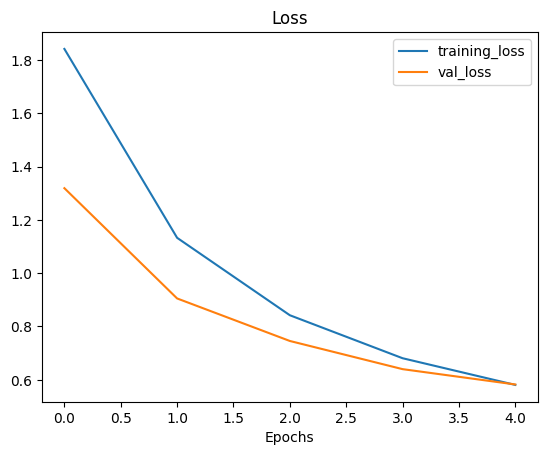

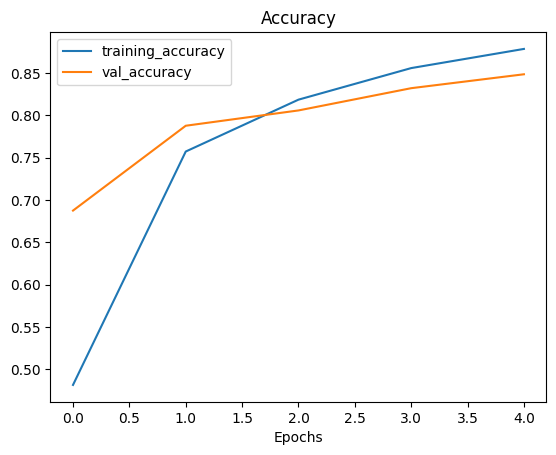

In [16]:
plot_loss_curves(history_10_percent)

**Getting a feature vector from a trained model**

- The **tf.keras.layers.GlobalAveragePooling2D()** layer transforms a 4D tensor into a 2D tensor by averaging the values acroos the inner-axes.

To explain.

For example we have a tensor of (1,4,4,3) then it is
- 1 then batch size
- 4,4 the image height and width
- 3 the color channels
*So we have 3 feature maps of size 4x4 each*

What **GlobalAveragePooling2D** does

- For each *4x4* whose count is 3, it computers the **average of all 16 numbers.**
- That turns each *4x4* into **1 number**










In [20]:
input_shape = (1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random Tensor is:\n {input_tensor}")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")



Random Tensor is:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]
2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


- As shown above the *tensor.keras.layers.GlobalAveragePooling2D()* layer condensed the input tensor of shape *(1,4,4,3)* to *(1,3)*
- It did so by averaging the *input_tensor* across the middle two axes

- We can do the above operation using *tf.reduce_mean()* by specifying the appropriate axes

In [21]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

**Running a Series of Transfer Learning Experiments**

- We saw that with only **10% of training data** we can achieve good results then what about **1%** of data.

We will run a few modelling experiments

- **Model 1:** Use feature extraction transfer learning on **1%** of training data with **data augmentation.**
- **Model 2:** Use **Feature Extraction Transfer Learning** on **10%** of training data with **data augmentation** and save the results to a checkpoint
- **Model 3:** Fine tune **Model 2** checkpoint on **10% of training data** with data augmentation
- **Model 4:** Fine tune **Model 2** checkpoint on *100%* of training data with data augmentation

- All of the above experiments will be carried out on different data, the evaluation will be done on **same test dataset** to ensure the results of each experiment are as comparable as possible.
- All the experiments will be done using **EfficientNetV2B0** model using the *tf.keras.applications.efficientnet_v2* module
- To keep track of experiments, we will use *create_tensorboard_callback()* function to log all the model training logs

- In the model instead of implementing **data augmentation** in the **ImageDataGenerator** class like previous practice, we will build it right into the model using *tf.keras.layers* module.

In [22]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip



--2025-09-24 08:14:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 64.233.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  31.4MB/s    in 4.9s    

2025-09-24 08:14:14 (25.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
unzip_data("10_food_classes_1_percent.zip")

In [24]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [25]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

**Load images** in the **tf.data.Dataset** objects.
- We will use the *image_dataset_from_directory()* method.

In [26]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            batch_size =32,
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)







Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


**Adding Data Augmentation Right into the Model**

- Previously we used *ImageDataGenerator* class for data augmentation of our training images.
- Now we are going to build *data augmentation* right into the model

We will use **tf.keras.layers** module and create a dedicated **data augmentation layer.**

*This concept is relatively new in TensorFlow 2.10 but is very powerful.It has the following benefits*

- Preprocessing of images (Augmenting them) happens on *GPU* rather than *CPU*
- Images are best preprocessed on *GPU* rather than *CPU*. *CPU* is more suited to **Text and Structured Data**.

- **Image Data Augmentation** only happens during **training** so we can still export our whole model and use it elsewhere which means that your trained model can be saved and shared without all the **augmented data** and the model **remember the features it learned.
- If someone wants to **retrain the model from scratch** or **train it on new data**, they might want to **use the same augmentation** to ensure that the model learns features in a robust way and we get consistent results.


**Important Note**
*When passed as a layer to a model data augmentation is automatically **turned on** during training and is not applied











- To use **data augmentation** right within our model we will create a **Keras Sequential Model** consisting of only **data preprocessing layers**
- We will use this **Sequential Model** within another **Functional Model.**

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation")

- **layers.RandomFlip:** flips image on horizontal or vertical axis
- **tf.keras.layers.RandomRotation:** randomly rotates image by a specified amount
- **tf.keras.layers.RandomZoom:** randomly zooms into an image by specified amount
- **tf.keras.layers.RandomHeight:** randomly shifts image height by a specified amount
- **tf.keras.layers.Rescaling:** normalizes the image pixel values to be between 0 and 1.

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),], name ="data_augmentation")
